In [ ]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

# Example LSTM model
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize and train your model
input_size = 10
hidden_size = 20
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define model parameters
input_size = 10
sequence_length = 3000
batch_size = 4

# Create a sample input tensor
sample_input = torch.randn(batch_size, sequence_length, input_size)

# Initialize the LSTM model
hidden_size = 20
num_layers = 2
output_size = 1

# Get the model's output for the sample input
model.eval()  # Set to evaluation mode
with torch.no_grad():
    sample_output = model(sample_input)

# Display sample input and output
sample_input, sample_output
print(sample_input.shape)
print(sample_output.shape)

# # Dummy input for tracing
# example_input = torch.rand(1, 5, input_size)

# # Convert to TorchScript
# traced_script_module = torch.jit.trace(model, example_input)

# # Optimize for mobile
# optimized_traced_model = optimize_for_mobile(traced_script_module)

# # Save the optimized model
# optimized_traced_model._save_for_lite_interpreter("optimized_lstm_model.ptl")


torch.Size([4, 5, 10])
torch.Size([4, 1])


#### Dataloader test

Top-level keys: ['#refs#', 'channel_matrix', 'config']
channel_matrix dataset shape: (256, 2, 18, 8, 3000)
channel_matrix dataset dtype: [('real', '<f8'), ('imag', '<f8')]
channel_matrix shape: (256, 2, 18, 8, 3000)
channel_matrix dtype: complex128
Dataset created with 767744 samples
Number of users: 256
Time samples per user: 3000
Sample index: 1000
X shape: torch.Size([4, 18, 8])
Y shape: torch.Size([4, 18, 8])
X statistics: mean=0.0000, std=0.0000
Y statistics: mean=0.0000, std=0.0000


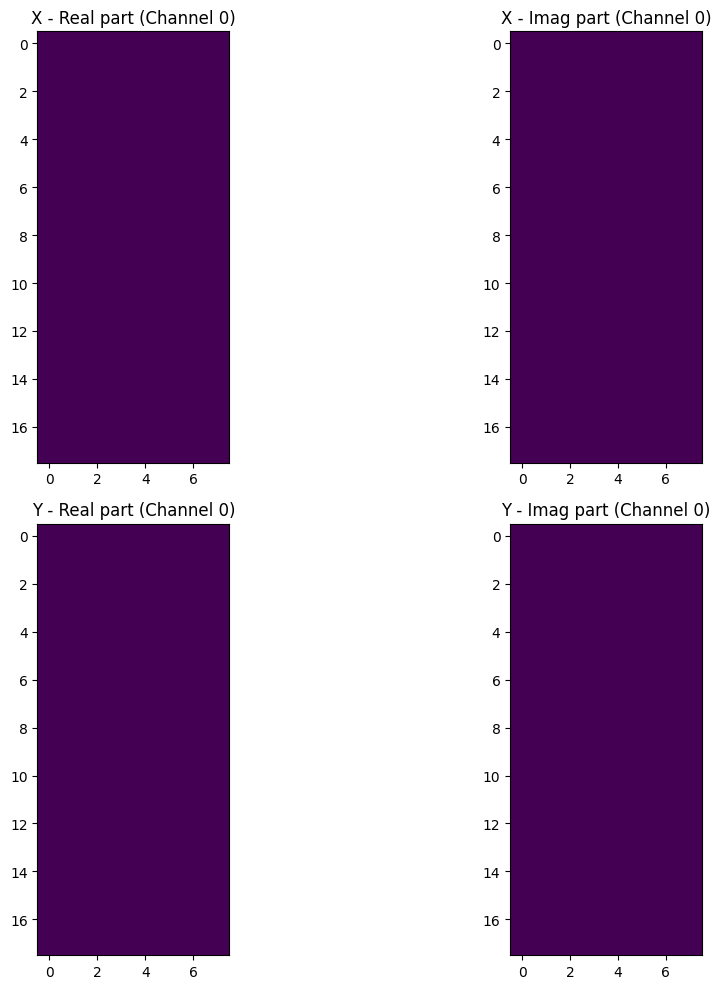

In [4]:
def test_channel_dataset():
    import h5py
    import numpy as np
    import matplotlib.pyplot as plt
    from dataloader import ChannelDataset

    filename = '/Users/muahmed/Desktop/Globecom 2025/nas-wireless/dataset/outputs/umi_compact_conf_8tx_2rx.mat'
    with h5py.File(filename, "r") as f:
        print("Top-level keys:", list(f.keys()))
        ds = f["channel_matrix"]
        print("channel_matrix dataset shape:", ds.shape)
        print("channel_matrix dataset dtype:", ds.dtype)

        # Check if dataset has compound dtype (typical for MATLAB complex arrays)
        if ds.dtype.fields is not None and "real" in ds.dtype.fields and "imag" in ds.dtype.fields:
            arr = ds[...]
            real_data = arr["real"]
            imag_data = arr["imag"]
            channel_matrix = real_data + 1j * imag_data
        else:
            # If it's not a compound dataset with 'real'/'imag', try direct conversion
            # (will fail if dtype=void or structured differently)
            channel_matrix = np.array(ds)
            if np.issubdtype(channel_matrix.dtype, np.void):
                raise TypeError("channel_matrix has a void/structured dtype and cannot be directly converted.")

    print("channel_matrix shape:", channel_matrix.shape)
    print("channel_matrix dtype:", channel_matrix.dtype)

    dataset = ChannelDataset(channel_matrix)
    print(f"Dataset created with {len(dataset)} samples")
    print(f"Number of users: {dataset.num_users}")
    print(f"Time samples per user: {dataset.time_length}")

    idx = 1000
    X, Y = dataset[idx]
    print(f"Sample index: {idx}")
    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")
    print(f"X statistics: mean={X.mean().item():.4f}, std={X.std().item():.4f}")
    print(f"Y statistics: mean={Y.mean().item():.4f}, std={Y.std().item():.4f}")

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].imshow(X[0].numpy())
    axs[0, 0].set_title("X - Real part (Channel 0)")
    axs[0, 1].imshow(X[2].numpy())
    axs[0, 1].set_title("X - Imag part (Channel 0)")
    axs[1, 0].imshow(Y[0].numpy())
    axs[1, 0].set_title("Y - Real part (Channel 0)")
    axs[1, 1].imshow(Y[2].numpy())
    axs[1, 1].set_title("Y - Imag part (Channel 0)")
    plt.tight_layout()
    plt.savefig('/Users/muahmed/Desktop/Globecom 2025/nas-wireless/channel_visualization.png')
    plt.show()

    return dataset

if __name__ == "__main__":
    test_channel_dataset()
